In [1]:
import os
import numpy as np
import pandas as pd
import random
from scipy import signal
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
from tqdm import tqdm

# Create output directories if they don't exist
os.makedirs("morse_data", exist_ok=True)
os.makedirs("morse_data/audio", exist_ok=True)

SAMPLE_FREQ = 8192  # 8 Khz
DURATION_SEC = 8    # Target duration of each audio file

MORSE_CODE_DICT = {
    "А": ".-",     "Б": "-...",   "В": ".--",    "Г": "--.",    "Д": "-..",
    "Е": ".",      "Ж": "...-",   "З": "--..",   "И": "..",     "Й": ".---",
    "К": "-.-",    "Л": ".-..",   "М": "--",     "Н": "-.",     "О": "---",
    "П": ".--.",   "Р": ".-.",    "С": "...",    "Т": "-",      "У": "..-",
    "Ф": "..-.",   "Х": "....",   "Ц": "-.-.",   "Ч": "---.",   "Ш": "----",
    "Щ": "--.-",   "Ъ": "--.--",  "Ы": "-.--",   "Ь": "-..-",   "Э": "..-..",
    "Ю": "..--",   "Я": ".-.-",   "1": ".----",  "2": "..---",  "3": "...--",
    "4": "....-",  "5": ".....",  "6": "-....",  "7": "--...",  "8": "---..",
    "9": "----.",  "0": "-----",  "#": "--.--",  " ": " " # решетка получена при ручном анализе файлов
}
ALPHABET = " " + "".join(MORSE_CODE_DICT.keys())


def get_spectrogram(samples):
    window_length = int(0.02 * SAMPLE_FREQ)  # 20 ms windows
    _, _, s = signal.spectrogram(samples, nperseg=window_length, noverlap=0)
    return s


def generate_sample(text_len=10, pitch=500, wpm=20, noise_power=1, amplitude=100, s=None):
    assert pitch < SAMPLE_FREQ / 2  # Nyquist

    # Reference word is PARIS, 50 dots long
    dot = (60 / wpm) / 50 * SAMPLE_FREQ

    # Add some noise on the length of dash and dot
    def get_dot():
        scale = np.clip(np.random.normal(1, 0.2), 0.5, 2.0)
        return int(dot * scale)

    # The length of a dash is three times the length of a dot.
    def get_dash():
        scale = np.clip(np.random.normal(1, 0.2), 0.5, 2.0)
        return int(3 * dot * scale)

    # Create random string that doesn't start or end with a space
    if s is None:
        s1 = ''.join(random.choices(ALPHABET, k=text_len - 2))
        s2 = ''.join(random.choices(ALPHABET[1:], k=2))
        s = s2[0] + s1 + s2[1]

    out = []
    out.append(np.zeros(5 * get_dot()))

    # The space between two signs of the same character is equal to the length of one dot.
    # The space between two characters of the same word is three times the length of a dot.
    # The space between two words is seven times the length of a dot (or more).
    for c in s:
        if c == ' ':
            out.append(np.zeros(7 * get_dot()))
        else:
            for m in MORSE_CODE_DICT[c]:
                if m == '.':
                    out.append(np.ones(get_dot()))
                    out.append(np.zeros(get_dot()))
                elif m == '-':
                    out.append(np.ones(get_dash()))
                    out.append(np.zeros(get_dot()))

            out.append(np.zeros(2 * get_dot()))

    out.append(np.zeros(5 * get_dot()))
    out = np.hstack(out)

    # Modulatation
    t = np.arange(len(out)) / SAMPLE_FREQ
    sine = np.sin(2 * np.pi * t * pitch)
    out = sine * out

    # Add noise
    noise_power = 1e-6 * noise_power * SAMPLE_FREQ / 2
    noise = np.random.normal(scale=np.sqrt(noise_power), size=len(out))
    out = 0.5 * out + noise

    out *= amplitude / 100
    out = np.clip(out, -1, 1)

    out = out.astype(np.float32)

    spec = get_spectrogram(out)

    return out, spec, s


def pad_to_duration(samples, target_duration_sec, sample_freq, noise_power):
    """Pad the audio sample with noise to reach the target duration"""
    target_length = int(target_duration_sec * sample_freq)
    current_length = len(samples)
    
    if current_length >= target_length:
        # If already longer than target, return as is
        return samples
    
    # Calculate padding needed
    padding_length = target_length - current_length
    left_padding = padding_length // 2
    right_padding = padding_length - left_padding
    
    # Generate noise with same characteristics as in the original signal
    noise_scale = np.sqrt(1e-6 * noise_power * SAMPLE_FREQ / 2)
    left_noise = np.random.normal(scale=noise_scale, size=left_padding)
    right_noise = np.random.normal(scale=noise_scale, size=right_padding)
    
    # Concatenate with original signal
    padded_samples = np.concatenate([left_noise, samples, right_noise])
    
    return padded_samples.astype(np.float32)


def generate_dataset(num_samples=5000):
    """Generate a dataset of morse code audio files with CSV metadata"""
    data = []
    
    for i in tqdm(range(num_samples)):
        # Random Morse parameters
        text_len = random.randint(7, 10)  # ← фикс по условию
        pitch = random.randrange(512, 2049)
        wpm = random.randrange(30, 35)
        noise_power = random.randrange(10, 100)
        amplitude = random.randrange(30, 120)
        
        # Генерируем случайную строку длиной text_len
        # Обязательно исключаем пробел в начале и в конце
        # chars = random.choices(ALPHABET.strip(), k=text_len)
        chars = random.choices(ALPHABET, k=text_len)

        if chars[0] == ' ':
            chars[0] = random.choice(ALPHABET[1:])
        if chars[-1] == ' ':
            chars[-1] = random.choice(ALPHABET[1:])
        text = ''.join(chars)
        
        # Генерация сигнала
        samples, _, _ = generate_sample(
            text_len, pitch, wpm, noise_power, amplitude, text
        )

        # Паддинг шумом до 8 секунд
        padded_samples = pad_to_duration(samples, DURATION_SEC, SAMPLE_FREQ, noise_power)

        # Сохраняем .wav
        filename = f"{i+1}.opus"
        filepath = os.path.join("morse_data/audio", filename)
        write(filepath, SAMPLE_FREQ, padded_samples)

        # Добавляем метаданные
        data.append({
            'id': filename, 
            'filename': filename,
            'message': text,
            'pitch': pitch,
            'wpm': wpm,
            'noise_power': noise_power,
            'amplitude': amplitude
        })

    # CSV с метками
    df = pd.DataFrame(data)
    df.to_csv("morse_data/metadata.csv", index=False)

    print(f"✅ Generated {num_samples} morse code audio files")
    print(f"📄 Metadata CSV saved to 'morse_data/metadata.csv'")



if __name__ == "__main__":
    # Generate 5000 samples
    generate_dataset(7500)

100%|██████████| 7500/7500 [00:29<00:00, 252.61it/s]

✅ Generated 7500 morse code audio files
📄 Metadata CSV saved to 'morse_data/metadata.csv'


In [32]:
import librosa

def open_file(path):
    file_path = path

    # Загружаем звук, приводим к 32kHz
    y, sr = librosa.load(file_path, sr=32000)

    file_name = path.split('/')[-1]
    # Проверим длительность
    # print(f"Имя файла: {file_name}")
    # print(f"Длительность: {len(y) / sr:.2f} сек, Частота: {sr} Гц")
    return y, sr


In [31]:
# Построим мел-спектрограмму
def get_mell(y_denoised, sr):
    S = librosa.feature.melspectrogram(y=y_denoised, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB


def draw_mell(S_dB, sr):
    # Отрисовка
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram (denoised)')
    plt.tight_layout()
    plt.show()

In [30]:
def path_to_files_from_n_to_m(n, m):
    base_path="morse_data/audio/"
    paths = list()
    for i in range(n, m):
        paths.append(base_path + str(i) + ".opus")
    return paths

morse_data/audio/1.opus


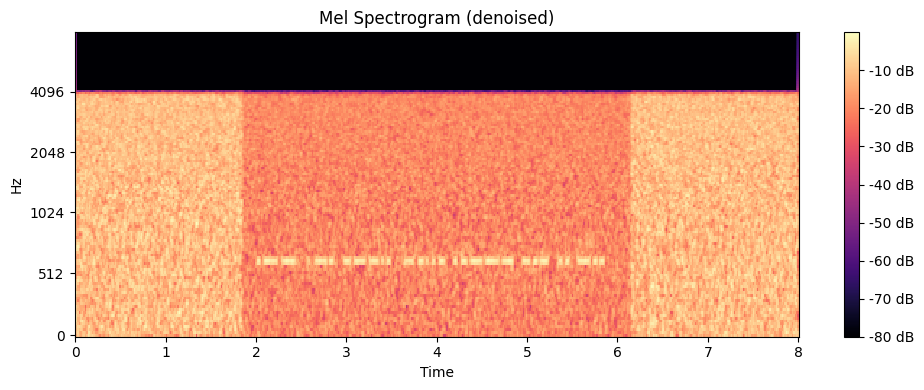

morse_data/audio/2.opus


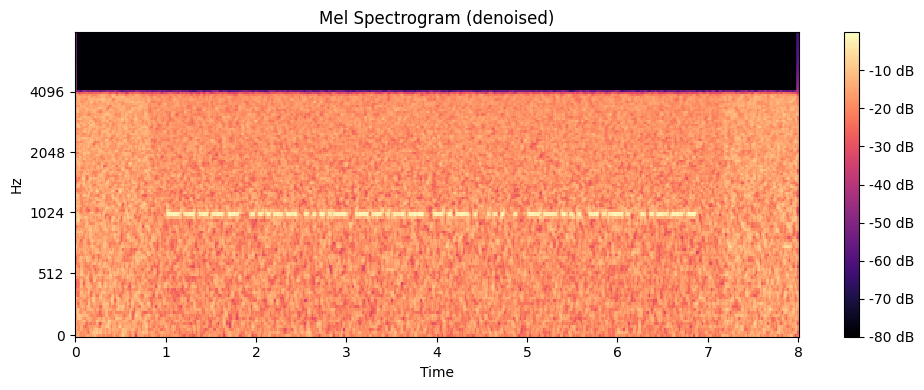

morse_data/audio/3.opus


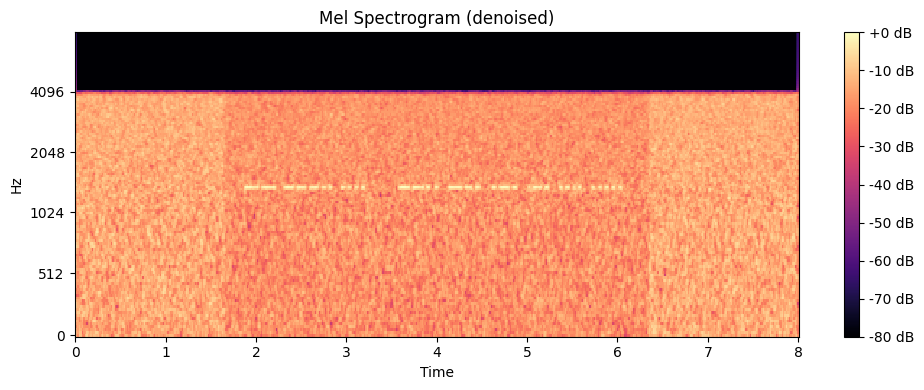

morse_data/audio/4.opus


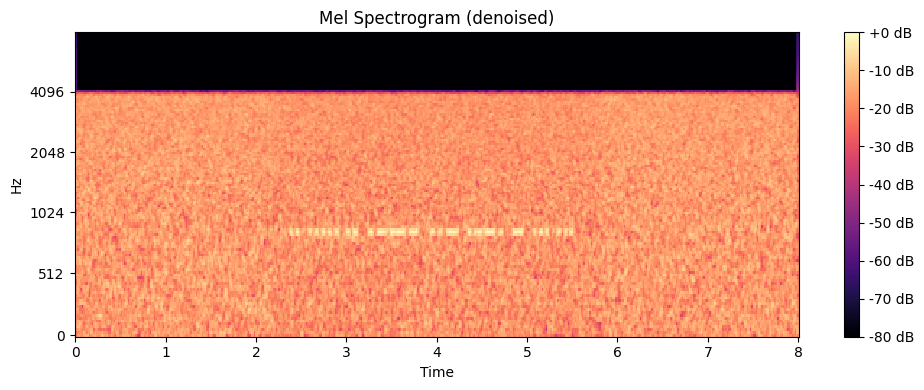

morse_data/audio/5.opus


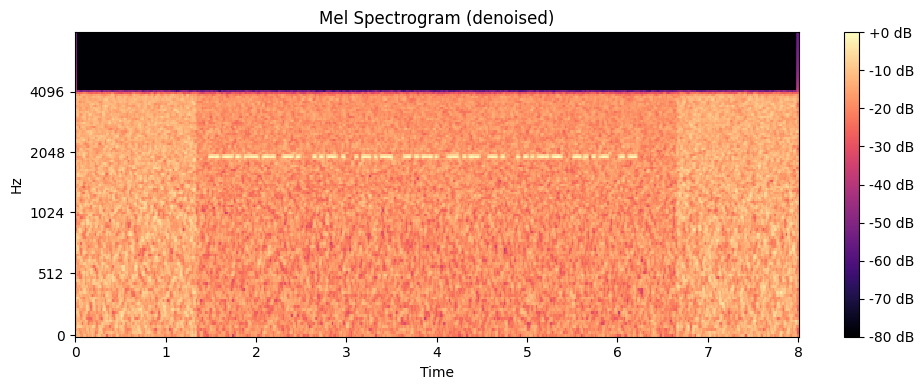

morse_data/audio/6.opus


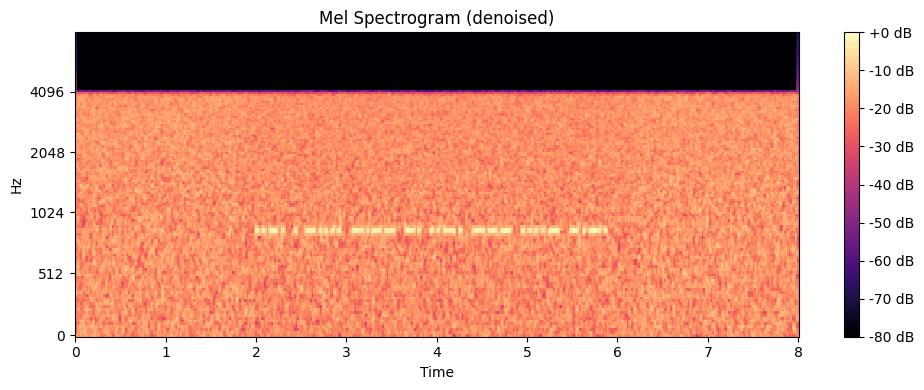

morse_data/audio/7.opus


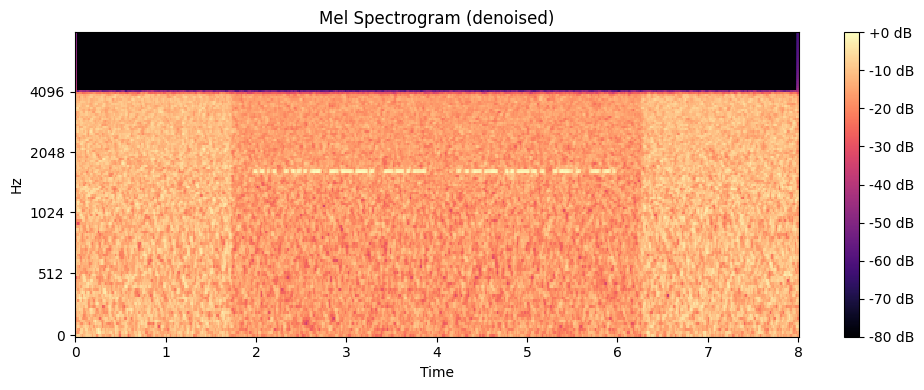

morse_data/audio/8.opus


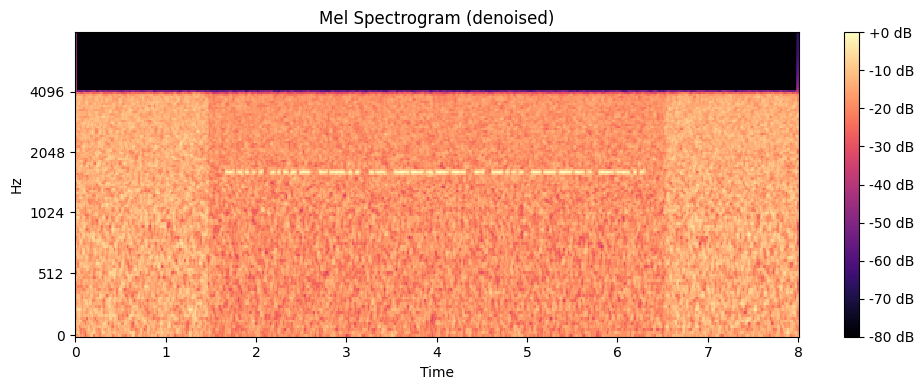

morse_data/audio/9.opus


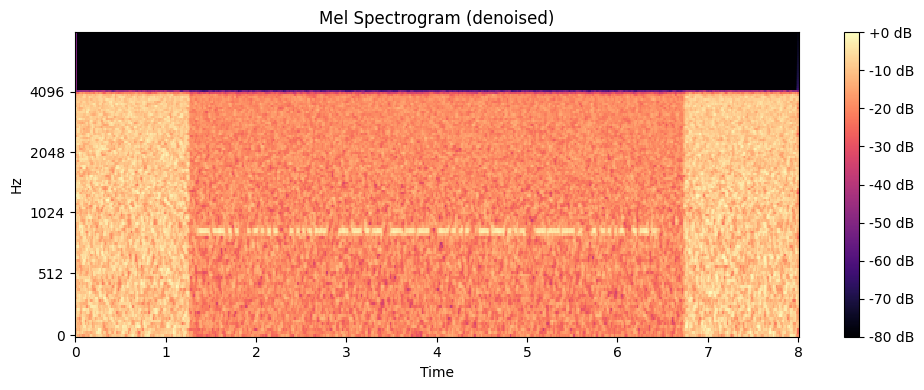

In [7]:
for i in path_to_files_from_n_to_m(1, 10):
    print(i)
    y, sr = open_file(i)
    S_db = get_mell(y, sr)
    
    # r = process_morse_audio(i, visualize=False)
    # S_db = r['spectrogram']
    # sr = r['sr']
    draw_mell(S_db, sr)

In [8]:
import pandas as pd 

pd.read_csv('morse_data/metadata.csv')

id   filename     message  pitch  wpm  noise_power  amplitude
0        1.opus     1.opus    ВР861КИД    627   31           78         36
1        2.opus     2.opus  034ЪЦСЕ7Ц2   1018   30           71         73
2        3.opus     3.opus  М8Х ЗГРРХ5   1372   32           82         64
3        4.opus     4.opus   И5ИЙУПТСС    866   32           88         92
4        5.opus     5.opus  ЪНФЯЦКН3ЬМ   1938   32           59         60
...         ...        ...         ...    ...  ...          ...        ...
7495  7496.opus  7496.opus  4М3Л# ВЭХЛ   2017   33           28         78
7496  7497.opus  7497.opus   3Ч 51ТГ #    523   33           42         32
7497  7498.opus  7498.opus     19У2ЪДО   1626   30           71         79
7498  7499.opus  7499.opus  2ШНЕКИНШВЯ   1008   33           61        119
7499  7500.opus  7500.opus   ТЯУВ67 ЗБ   1793   33           98         50

[7500 rows x 7 columns]

In [33]:
def path_to_files_from_n_to_m(n, m):
    base_path="D:/pypy/kontur/data/morse_dataset/morse_dataset/"
    paths = list()
    for i in range(n, m):
        paths.append(base_path + str(i) + ".opus")
    return paths

In [59]:
import librosa
import numpy as np

def auto_trim(y, sr, db_range=range(9, 31), margin_sec=1.0):
    """
    Автоматически подбирает top_db и возвращает сигнал с запасом по краям.
    
    :param y: аудиосигнал
    :param sr: sample rate
    :param db_range: диапазон перебора top_db (например, range(13, 31))
    :param margin_sec: запас в секундах с каждой стороны
    :return: обрезанный сигнал
    """
    lengths = []
    trims = []

    # Пробуем обрезку при разных top_db
    for top_db in db_range:
        y_trimmed, (start, end) = librosa.effects.trim(y, top_db=top_db)
        length = end - start
        lengths.append(length)
        trims.append((start, end))

    # Находим топ_db, при котором длина почти не растёт
    diffs = np.diff(lengths)
    stable_idx = np.argmax(diffs <= 1000)  
    if stable_idx == 0:
        best_idx = 0
    else:
        best_idx = stable_idx - 1

    start, end = trims[best_idx]

    # Добавляем margin
    margin = int(sr // 2 * margin_sec)
    new_start = max(0, start - margin)
    new_end = min(len(y), end + margin)

    return y[new_start:new_end], db_range[best_idx]


D:/pypy/kontur/data/morse_dataset/morse_dataset/34984.opus
Использован top_db = 11


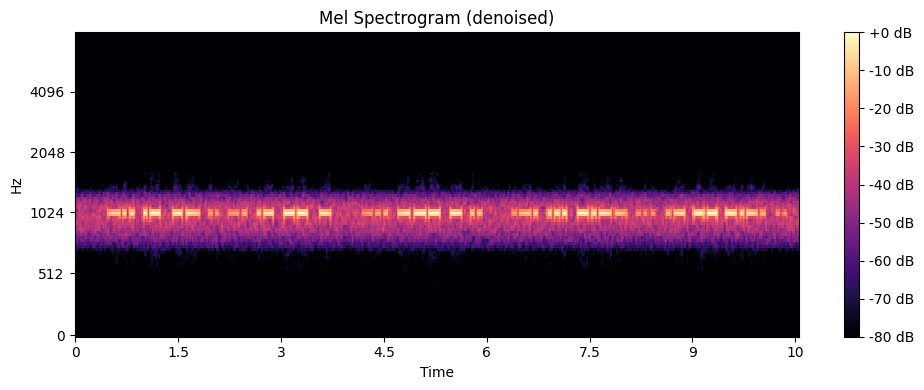

D:/pypy/kontur/data/morse_dataset/morse_dataset/34985.opus
Использован top_db = 10


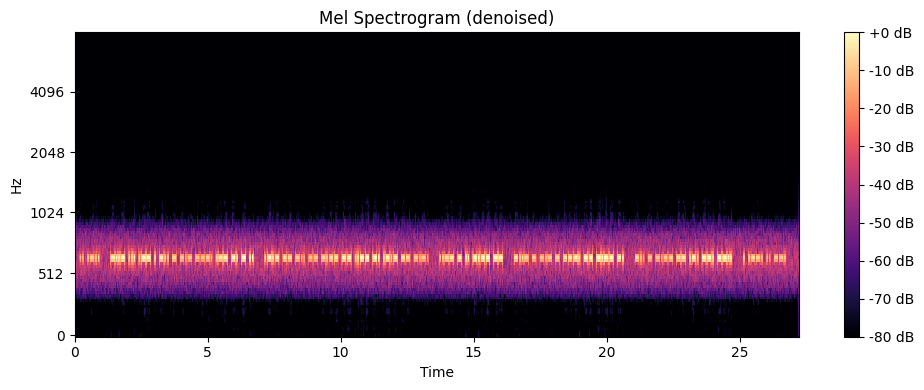

D:/pypy/kontur/data/morse_dataset/morse_dataset/34986.opus
Использован top_db = 9


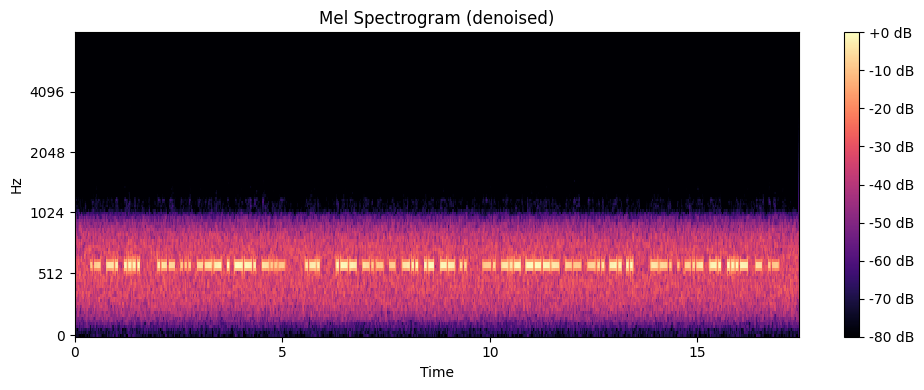

D:/pypy/kontur/data/morse_dataset/morse_dataset/34987.opus
Использован top_db = 9


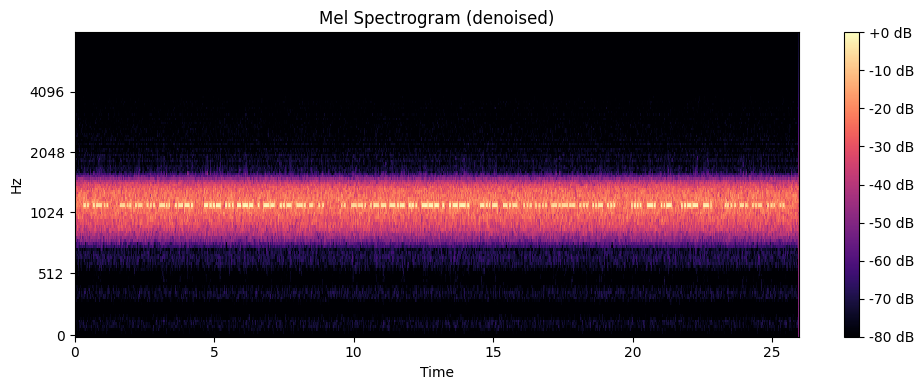

D:/pypy/kontur/data/morse_dataset/morse_dataset/34988.opus
Использован top_db = 9


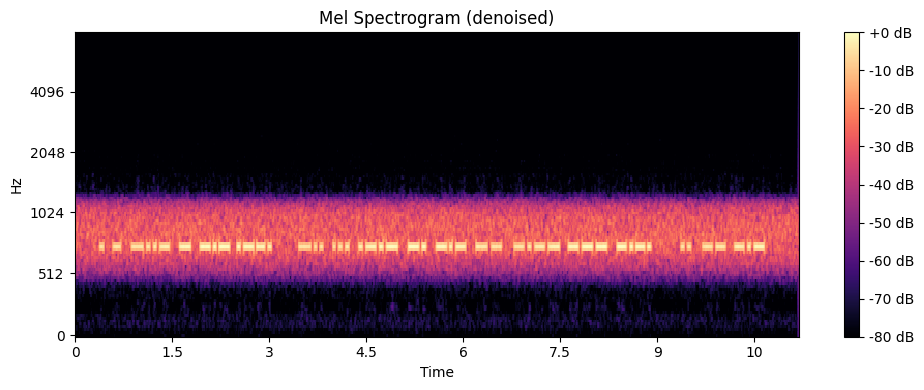

D:/pypy/kontur/data/morse_dataset/morse_dataset/34989.opus
Использован top_db = 9


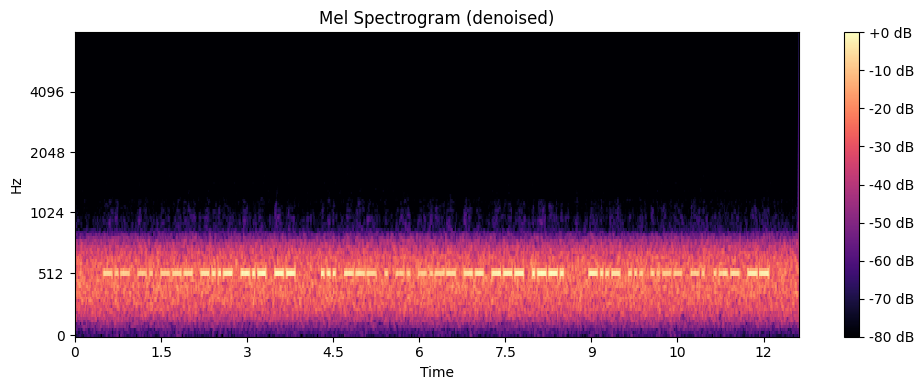

D:/pypy/kontur/data/morse_dataset/morse_dataset/34990.opus
Использован top_db = 9


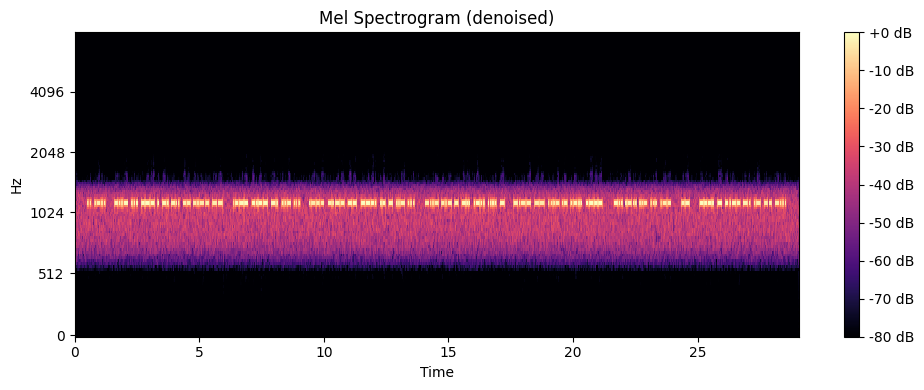

D:/pypy/kontur/data/morse_dataset/morse_dataset/34991.opus
Использован top_db = 12


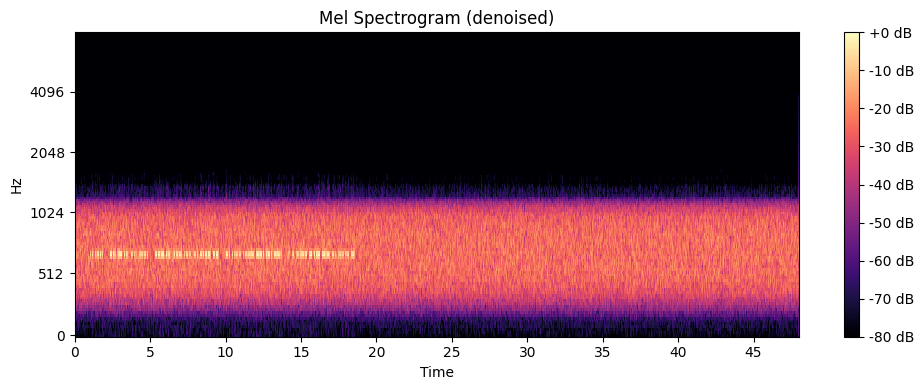

D:/pypy/kontur/data/morse_dataset/morse_dataset/34992.opus
Использован top_db = 9


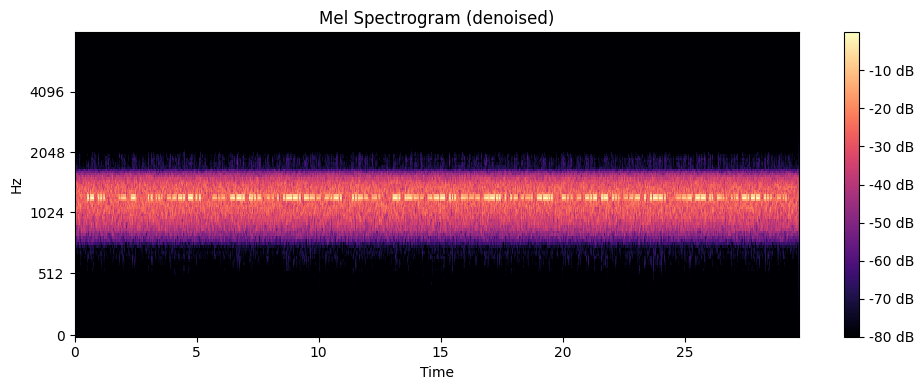

D:/pypy/kontur/data/morse_dataset/morse_dataset/34993.opus
Использован top_db = 11


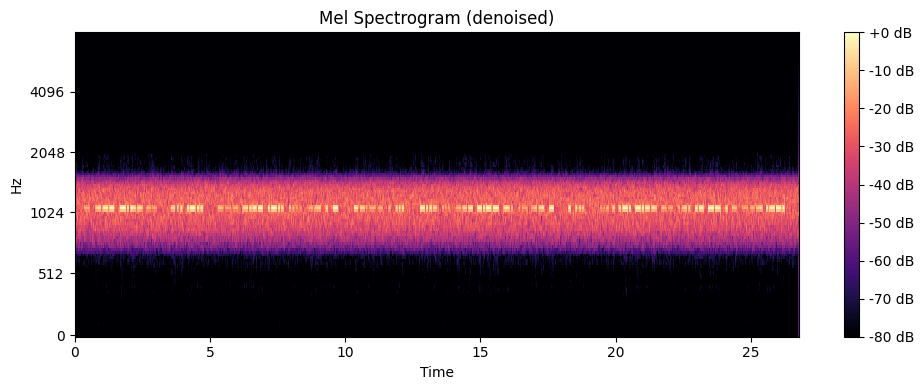

D:/pypy/kontur/data/morse_dataset/morse_dataset/34994.opus
Использован top_db = 9


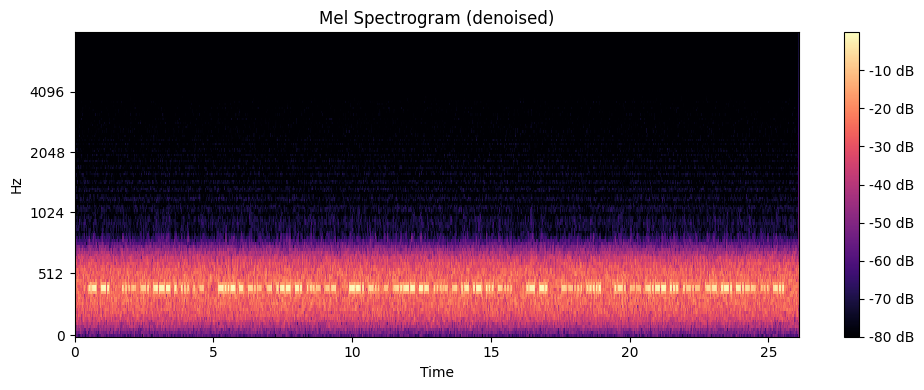

D:/pypy/kontur/data/morse_dataset/morse_dataset/34995.opus
Использован top_db = 9


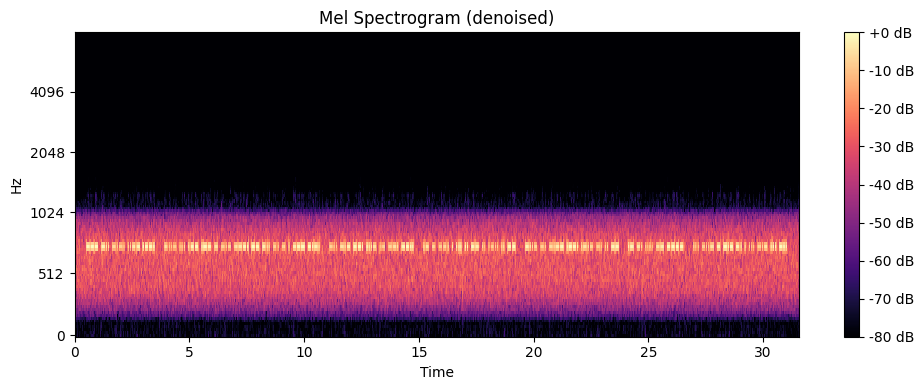

D:/pypy/kontur/data/morse_dataset/morse_dataset/34996.opus
Использован top_db = 9


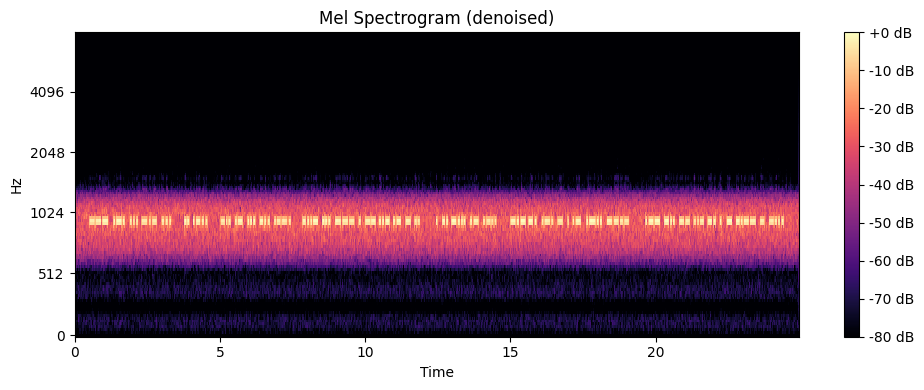

D:/pypy/kontur/data/morse_dataset/morse_dataset/34997.opus
Использован top_db = 9


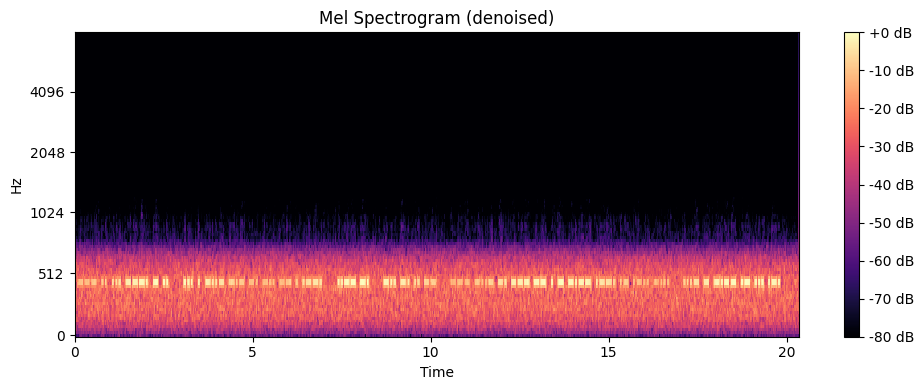

D:/pypy/kontur/data/morse_dataset/morse_dataset/34998.opus
Использован top_db = 9


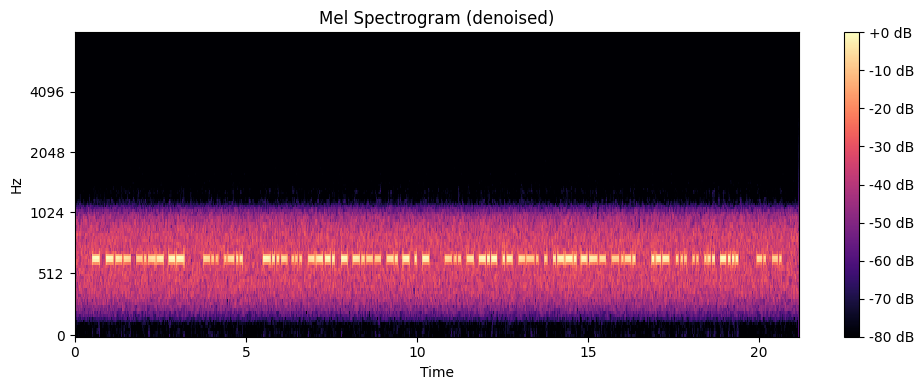

D:/pypy/kontur/data/morse_dataset/morse_dataset/34999.opus
Использован top_db = 9


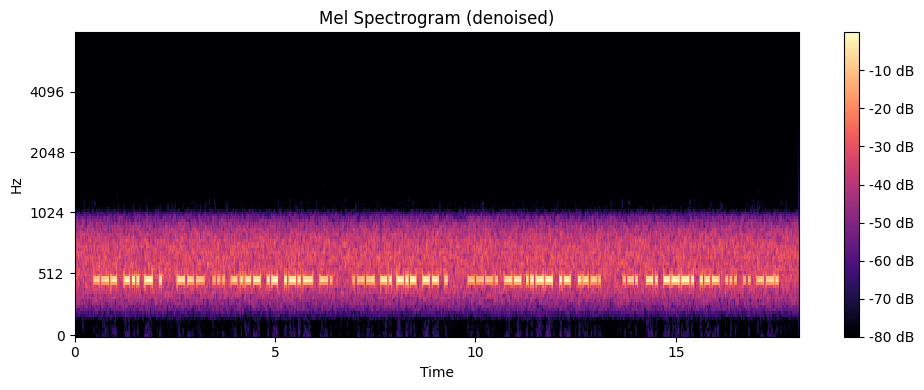

D:/pypy/kontur/data/morse_dataset/morse_dataset/35000.opus
Использован top_db = 11


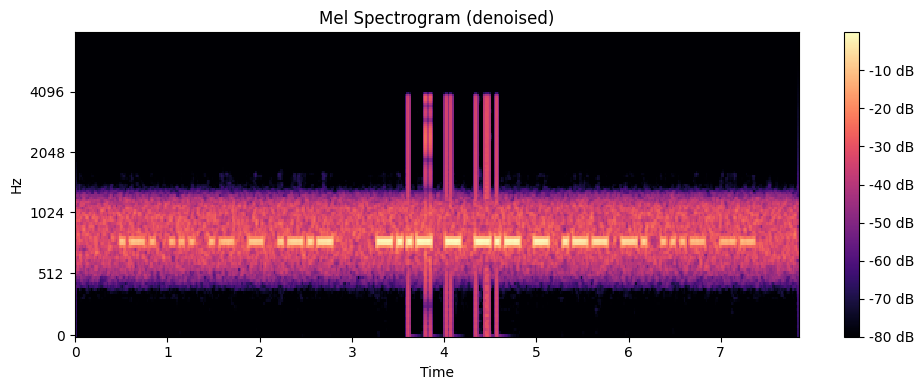

In [60]:
for i in path_to_files_from_n_to_m(34984, 35001):
    print(i)
    y, sr = open_file(i)
    y_trimmed, used_db = auto_trim(y, sr)
    print(f"Использован top_db = {used_db}")

    S_db = get_mell(y_trimmed, sr)
    
    # r = process_morse_audio(i, visualize=False)
    # S_db = r['spectrogram']
    # sr = r['sr']
    draw_mell(S_db, sr)

Обрабатываю: D:/pypy/kontur/data/morse_dataset/morse_dataset/34984.opus
Общая длительность: 9.92 сек


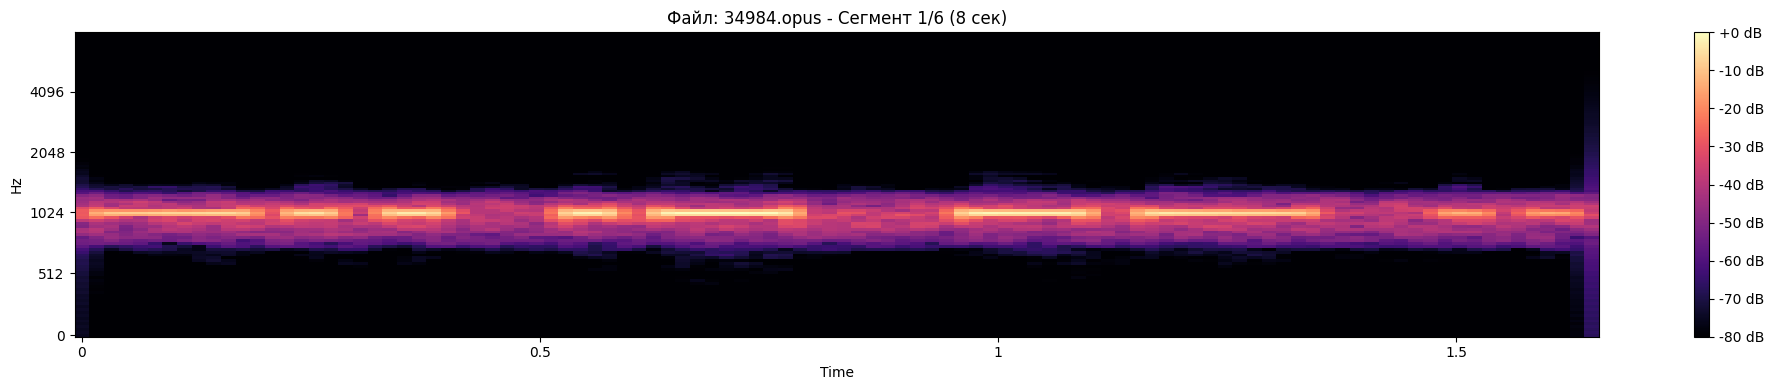

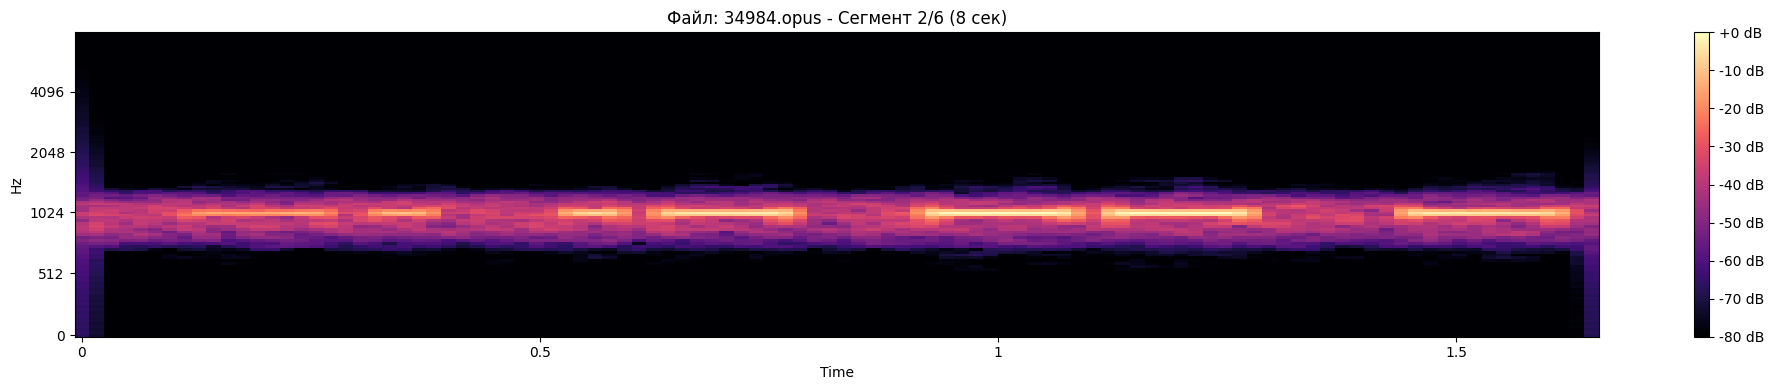

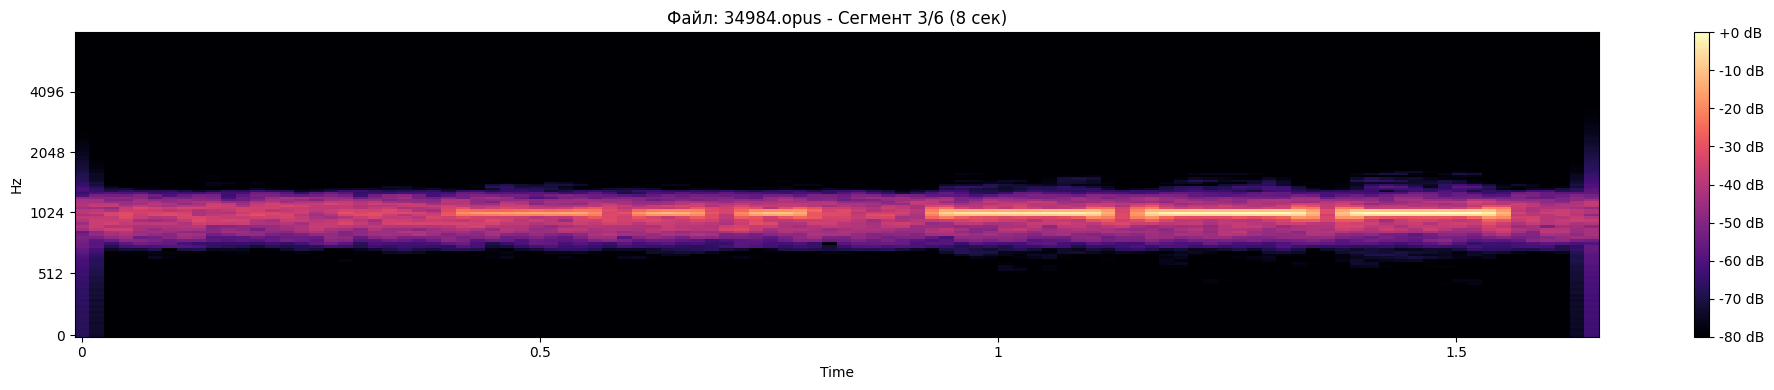

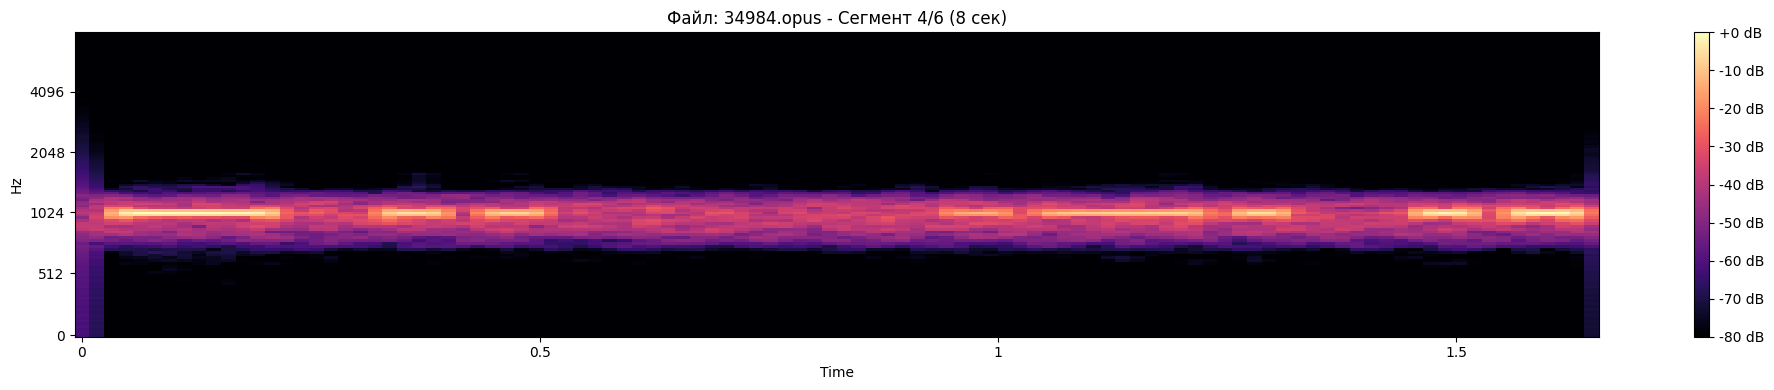

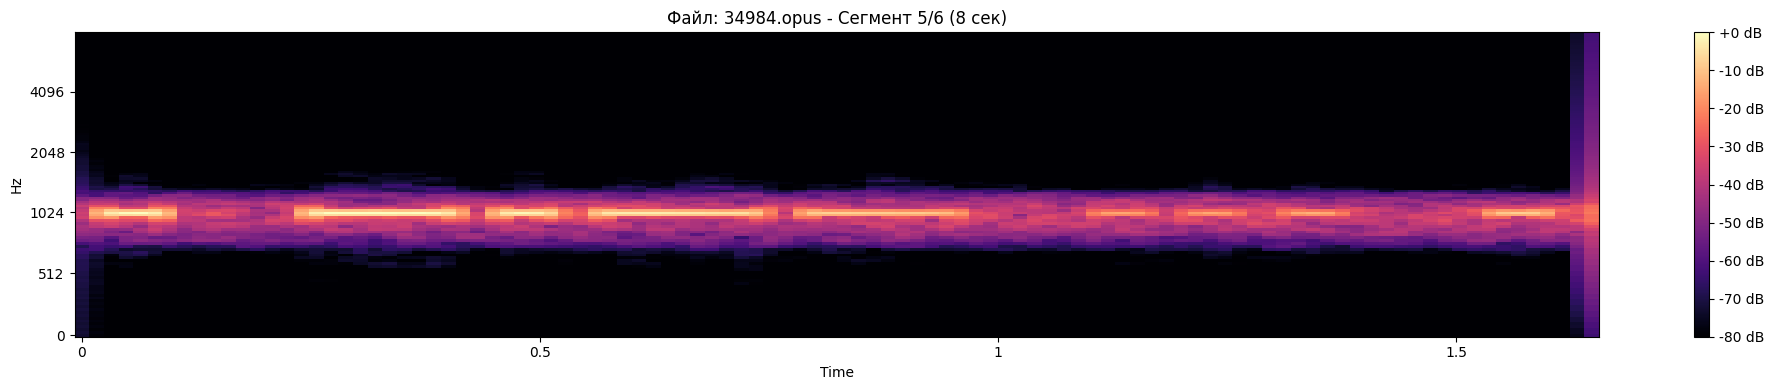

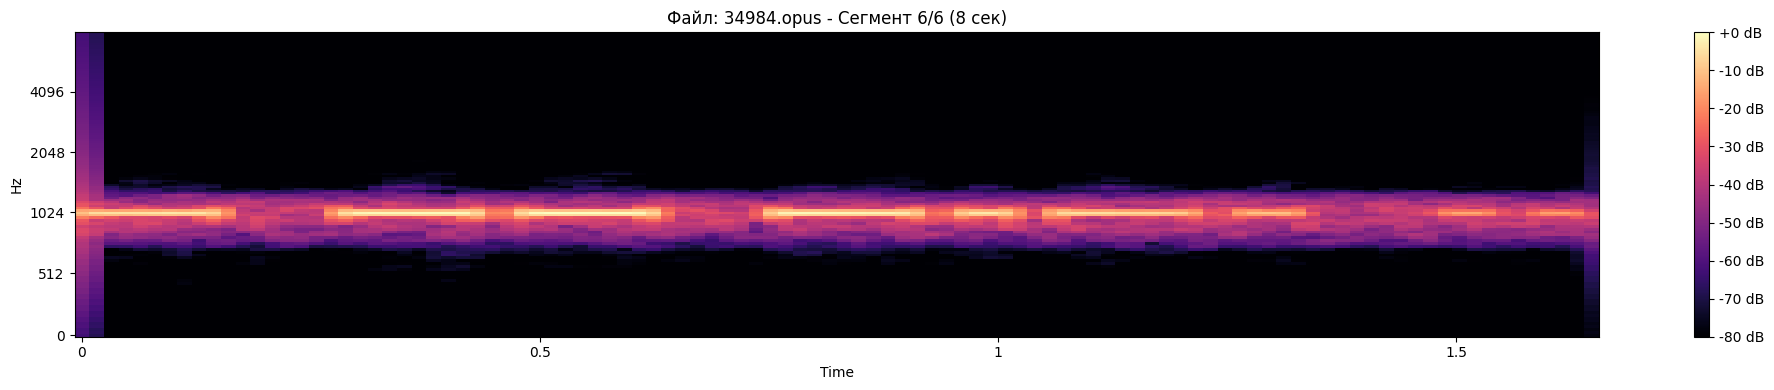

Обрабатываю: D:/pypy/kontur/data/morse_dataset/morse_dataset/34985.opus
Общая длительность: 26.58 сек


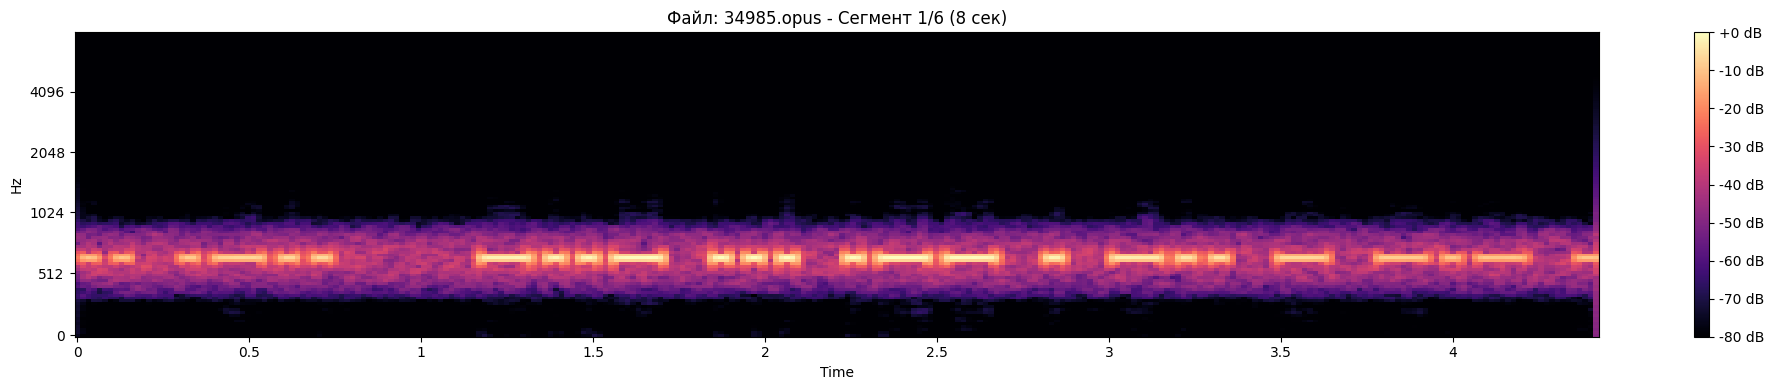

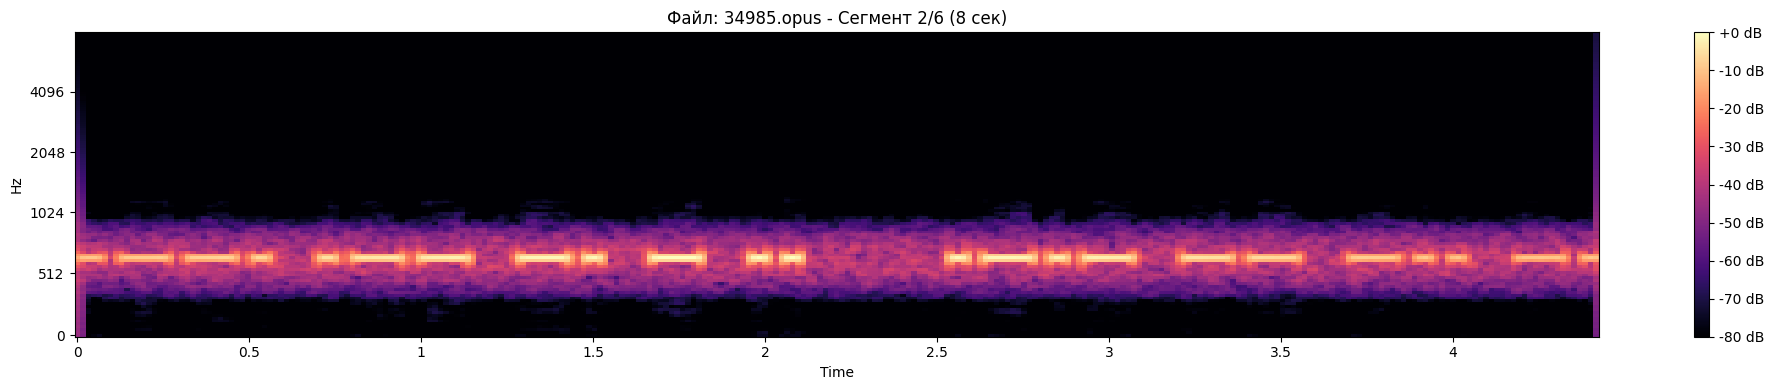

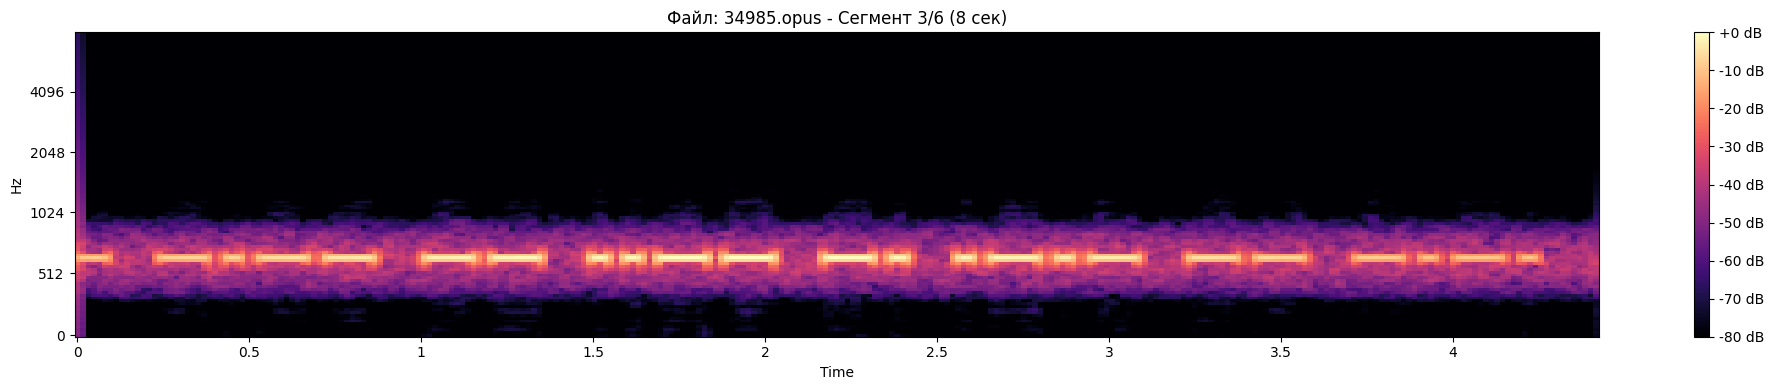

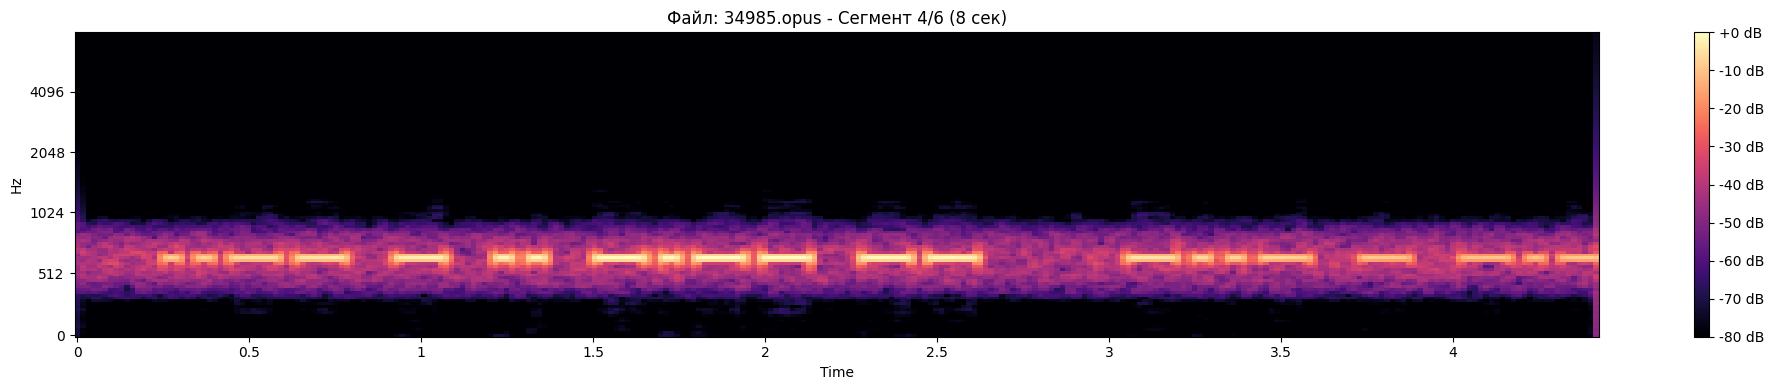

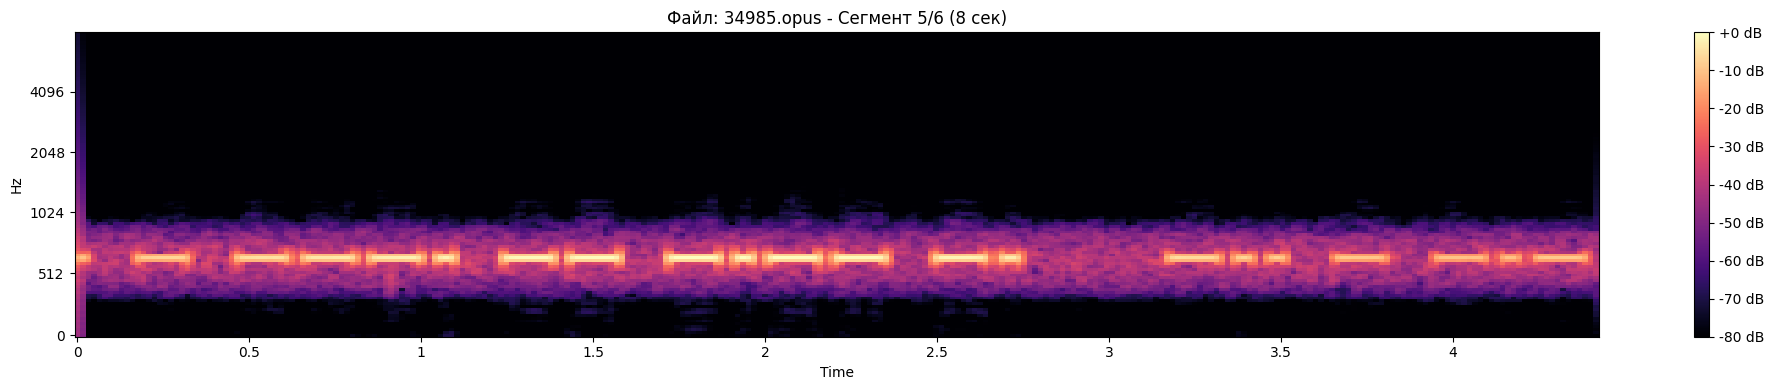

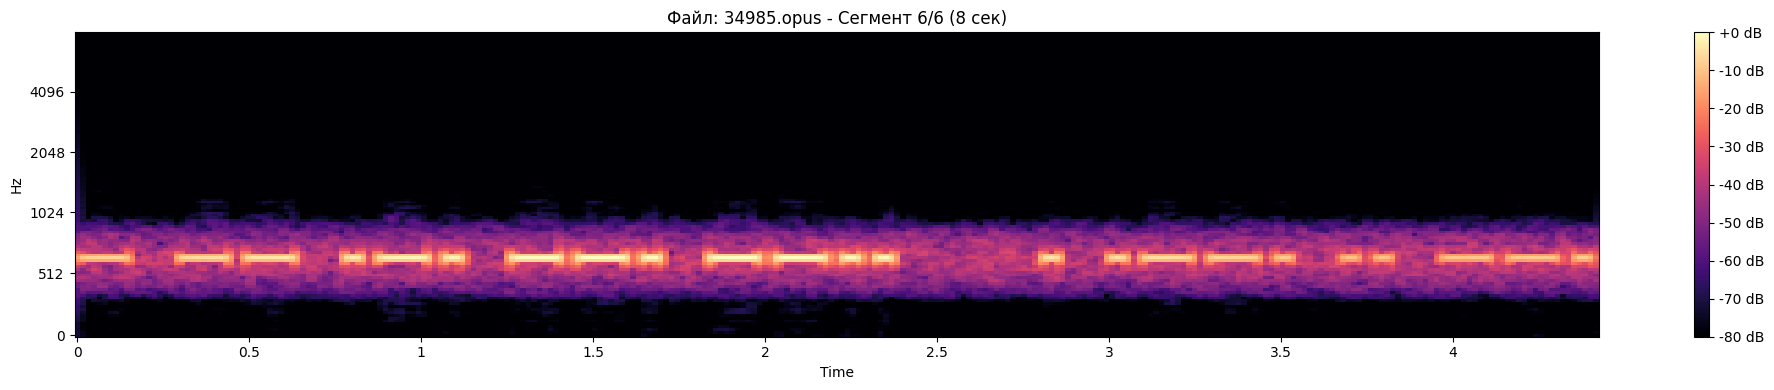

In [26]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def open_file(path):
    file_path = path 
    # Загружаем звук, приводим к 32kHz
    y, sr = librosa.load(file_path, sr=32000)
    
    file_name = path.split('/')[-1]
    # Проверим длительность
    # print(f"Имя файла: {file_name}")
    # print(f"Длительность: {len(y) / sr:.2f} сек, Частота: {sr} Гц")

    # Обрезает сигнал с начала и конца по уровню энергии
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)

    return y_trimmed, sr

# Построим мел-спектрограмму для конкретного сегмента аудио
def get_mell(y_segment, sr):
    S = librosa.feature.melspectrogram(y=y_segment, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

# Функция для отрисовки мел-спектрограммы одного сегмента во всю ширину
def draw_mell_segment(S_dB, sr, segment_index, total_segments, file_name):
    plt.figure(figsize=(20, 4))  # Увеличенная ширина для лучшей детализации
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Файл: {file_name} - Сегмент {segment_index+1}/{total_segments} (8 сек)')
    plt.tight_layout()
    plt.show()

def path_to_files_from_n_to_m(n, m):
    base_path = "D:/pypy/kontur/data/morse_dataset/morse_dataset/"
    paths = []
    for i in range(n, m):
        paths.append(base_path + str(i) + ".opus")
    return paths

def process_file_in_segments(file_path, segment_duration=8, num_segments=6):
    print(f"Обрабатываю: {file_path}")
    y, sr = open_file(file_path)
    
    # Вычисляем общую длительность файла
    total_duration = len(y) / sr
    print(f"Общая длительность: {total_duration:.2f} сек")
    
    file_name = file_path.split('/')[-1]
    
    # Если аудио короче требуемой длительности для 6 сегментов
    if total_duration < segment_duration * num_segments:
        # Разделим доступное аудио на num_segments равных частей
        segment_size = len(y) // num_segments
        
        for i in range(num_segments):
            start_sample = i * segment_size
            end_sample = (i + 1) * segment_size if i < num_segments - 1 else len(y)
            segment = y[start_sample:end_sample]
            
            # Получаем мел-спектрограмму для сегмента
            S_db = get_mell(segment, sr)
            
            # Рисуем спектрограмму на весь экран
            draw_mell_segment(S_db, sr, i, num_segments, file_name)
    else:
        # Если аудио достаточно длинное, берем 6 сегментов по 8 секунд
        for i in range(num_segments):
            start_sec = i * segment_duration
            start_sample = int(start_sec * sr)
            end_sample = int((start_sec + segment_duration) * sr)
            
            # Проверка, чтобы не выйти за пределы аудио
            if end_sample > len(y):
                end_sample = len(y)
            
            segment = y[start_sample:end_sample]
            
            # Получаем мел-спектрограмму для 8-секундного сегмента
            S_db = get_mell(segment, sr)
            
            # Рисуем спектрограмму на весь экран
            draw_mell_segment(S_db, sr, i, num_segments, file_name)

# Обработка файлов
for file_path in path_to_files_from_n_to_m(34984, 34986):
    process_file_in_segments(file_path, segment_duration=8, num_segments=6)
    


In [23]:
#1 ДАМИНАМТДОТИРСЫСАМЦИ
#2 ИЛЬСВЕДТКЧВНТИЯМДМЫМЮНЯМЦ ЮТИЫМЬТКТЧМЫНДТЫМРГЗЕПИГ   
#3 АНХВСОЕГЬРВКНДАМИНКШМДНИГЕКНЖТА
#4 ИЛДАСДПЬСОЕМУНТИИГВКСОЕПЬКСХЫСУСХНУЮНХНУСИ
#5

#верный в ручную отредаченные варианты 
# 34984.opus,ДАМИНАМТ ДОТИ РСЫСАМЦИ
# 34985.opus,ИЛ ЬСВЕДТКЧВНТИ ЯМДМЫМЮНЯМЦ ЮТИЫМ ЬТКТЧМЫН ДТЫМРГЗ ЕПИГ
# 34986.opus,АНХ ВСОЕГЬ Р ВКТДАМИ НКШМДНИ ГЕКНЖТА
# 34987.opus,ИЛ ДАСДП ЬСОЕМУНТИ ИГВКСОЕП ЬКСХЫСУС ХНУ ЮН ХНУСИ     
# 34988.opus,ЕТЬТКП ДСЯНКМЫОЦ ИМК
# 34989.opus,КНОЬКМ СОЕНЫМОП ЬСЮНВМ
# 34990.opus,ИЛ ЬСОЕНДМЫМ ЙЫНУС ЙЫМЧАТУС ЬКТДЛХТ ЫМЖАЛШ ДЛУСВ М ЧТЫНАМБ
# 34991.opus,ИЛ ДАСДП ОСЮВНЫМ НЮЙГРГ ЕТЫТУКНЩН
# 34992.opus,АС АТ ИСЧТИ КГЖНЕПОЦ ЮН НЙОСЫЗЕАГЗ ДТКАСОЕП ОМИДСЫСД
# 34993.opus,ТОЫМ ДЛ ОЫЛХМЕТ #ЕС ЬСОЫНАМТ ЕС СЕРЫМРАМЕТОП
# 34994.opus,АН ЖНОЕСЕТ ЬТКТВНЖМ ГДТЫМЖТААСБ АН 75 РМЫСЯМРЫСД
# 34995.opus,ОДЦЮП ЬСВВТКЧМДНТЕОЦ ДКГЖАГЗ АТГЕСИМИЛИМ ЬНЫПЯНИМ АНХМШ СЬТКНЕСКСД
# 34996.opus,ОРСКС ИЛ ДАСДП ЬСОЕМУАТИ ЕНБАЛ КНРТЕАЛШ ВДМУНЕТЫТБ
# 34997.opus,ОИСЧТИ СЕЬКНДМЕП ЮН ДНИМ ОЬНОМЕТЫПАЛБ ЖТЫАСР
# 34998.opus,ТОЫМ ДЛ ЬСЧТЫНТЕТ ДТКАГЕПОЦ ВСИСБ НН
# 34999.opus,ОДТЕ ОСЫАЯН ВНКМЕ ЧМЮАП РНЧВСИГ
# 35000.opus,РСАТЯ ЬТКТВНЖМ

In [3]:
txt = """-.. .- -- .. -. .- -- -  -.. --- - ..  .-. ... -.-- ... .- -- -.-. .. 
 .. .-..  -..- ... .-- . -.. - -.- ---. .-- -. - ..  .-.- -- -.. -- -.-- -- ..-- -. .-.- -- -.-.  ..-- - .. -.-- --  -..- - -.- - ---. -- -.-- -.  -.. - -.-- -- .-. --. --..  . .--. .. --. 
 .- -. ....  .-- ... --- . --. -..-  .-.  .-- -.- - -.. .- -- ..  -. -.- ---- -- -.. -. ..  --. . -.- -. ...- - .- 
 .. .-..  -.. .- ... -.. .--.  -..- ... --- . -- ..- -. - ..  .. --. .-- -.- ... --- . .--.  -..- -.- ... .... -.-- ... ..- ...  .... -. ..-  ..-- -.  .... -. ..- ... ..      
 . - -..- - -.- .--.  -.. ... .-.- -. -.- -- -.-- --- -.-.  .. -- -.- 
 -.- -. --- -..- -.- --  ... --- . -. -.-- -- --- .--.  -..- ... ..-- -. .-- -- 
 .. .-..  -..- ... --- . -. -.. -- -.-- --  .--- -.-- -. ..- ...  .--- -.-- -- ---. .- - ..- ...  -..- -.- - -.. .-.. .... -  -.-- -- ...- .- .-.. ----  -.. .-.. ..- ... .--  --  ---. - -.-- -. .- -- -... 
 .. .-..  -.. .- ... -.. .--.  --- ... ..-- .-- -. -.-- --  -. ..-- .--- --. .-. --.  . - -.-- - ..- -.- -. --.- -. 
 .- ...  .- -  .. ... ---. - ..  -.- --. ...- -. . .--. --- -.-.  ..-- -.  -. .--- --- ... -.-- --.. . .- --. --..  -.. - -.- .- ... --- . .--.  --- -- .. -.. ... -.-- ... -.. 
 - --- -.-- --  -.. .-..  --- -.-- .-.. .... -- . -  # . ...  -..- ... --- -.-- -. .- -- -  . ...  ... . .-. -.-- -- .-. .- -- . - --- .--. 
 .- -.  ...- -. --- . ... . -  -..- - -.- - .-- -. ...- --  --. -.. - -.-- -- ...- - .- .- ... -...  .- -.  --... .....  .-. -- -.-- ... .-.- -- .-. -.-- ... -.. 
 --- -.. -.-. ..-- .--.  -..- ... .-- .-- - -.- ---. -- -.. -. - . --- -.-.  -.. -.- --. ...- .- --. --..  .- - --. . ... .. -- .. .-.. .. --  -..- -. -.-- .--. .-.- -. .. --  .- -. .... -- ----  ... -..- - -.- -. . ... -.- ... -.. 
 --- .-. ... -.- ...  .. .-..  -.. .- ... -.. .--.  -..- ... --- . -- ..- .- - ..  . -. -... .- .-..  -.- -. .-. - . .- .-.. ----  .-- -.. -- ..- -. . - -.-- - -... 
 --- .. ... ---. - ..  ... . -..- -.- -. -.. -- . .--.  ..-- -.  -.. -. .. --  --- -..- -. --- -- . - -.-- .--. .- .-.. -...  ...- - -.-- .- ... .-. 
 - --- -.-- --  -.. .-..  -..- ... ---. - -.-- -. - . -  -.. - -.- .- --. . .--. --- -.-.  .-- ... .. ... -...  -. -. 
 --- -.. - .  --- ... -.-- .- .-.- -.  .-- -. -.- -- .  ---. -- ..-- .- .--.  .-. -. ---. .-- ... .. --. 
 .-. ... .- - .-.-  -..- - -.- - .-- -. ...- --"""
txt_new = ''

for i in txt:
    if i == '.':
        txt_new += '-'
    elif i == '-':
        txt_new += '.'
    else:
        txt_new += ' '
    
print(txt_new)

.-- -. .. -- .- -. .. .  .-- ... . --  -.- --- .-.. --- -. .. .-.- --   -- -.--  .--. --- -.. - .-- . .-. ...- -.. .- . --  -.-. .. .-- .. .-.. .. --.. .- -.-. .. .-.-  --.. . -- .-.. ..  .--. . .-. . ...- .. .-.. .-  .-- . .-.. .. -.- ..- ..--  - -..- -- ..-   -. .- ----  -.. --- ... - ..- .--.  -.-  -.. .-. . .-- -. .. --  .- .-. .... .. .-- .- --  ..- - .-. .- ---. . -.   -- -.--  .-- -. --- .-- -..-  .--. --- ... - .. --. .- . --  -- ..- -.. .-. --- ... - -..-  .--. .-. --- ---- .-.. --- --. ---  ---- .- --.  --.. .-  ---- .- --. --- --        - . .--. . .-. -..-  .-- --- -.-. .- .-. .. .-.. ... .-.-  -- .. .-.   .-. .- ... .--. .-. ..  --- ... - .- .-.. .. ... -..-  .--. --- --.. .- -.. ..   -- -.--  .--. --- ... - .- .-- .. .-.. ..  -... .-.. .- --. ---  -... .-.. .. ...- -. . --. ---  .--. .-. . .-- -.-- ---- .  .-.. .. ---. -. -.-- ....  .-- -.-- --. --- -..  ..  ...- . .-.. .- -. .. .---   -- -.--  .-- -. --- .-- -..-  ... --- --.. -.. .- .-.. ..  .- --.. -... ..- -.- ..-  - .